In [1]:
import pandas as pd
import numpy as np

In [2]:
d = pd.read_csv('AMLPaysim.csv')

In [3]:
d.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
d.drop('nameOrig', axis=1, inplace=True)
d.drop('nameDest', axis=1, inplace=True)
d.drop('isFlaggedFraud', axis=1, inplace=True)

In [8]:
d.shape

(6362620, 8)

In [43]:
d_sample = d.sample(n = 50000)

X = d_sample.iloc[:, :-1].values
y = d_sample.iloc[:, 7].values

print(d_sample.isFraud.value_counts())

0    49928
1       72
Name: isFraud, dtype: int64


In [44]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
X[:, 1] = le.fit_transform(X[:, 1])
ohe = OneHotEncoder(categorical_features = [1])
X = ohe.fit_transform(X).toarray()

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


Dummy Variable Trap: 
The Dummy variable trap is a scenario where there are attributes which are highly correlated (Multicollinear) and one variable predicts the value of others. When we use one hot encoding for handling the categorical data, then one dummy variable (attribute) can be predicted with the help of other dummy variables. Hence, one dummy variable is highly correlated with other dummy variables. Using all dummy variables for regression models lead to dummy variable trap. So, the regression models should be designed excluding one dummy variable.

For Example –
Let’s consider the case of gender having two values male (0 or 1) and female (1 or 0). Including both the dummy variable can cause redundancy because if a person is not male in such case that person is a female, hence, we don’t need to use both the variables in regression models. This will protect us from dummy variable trap.

In [45]:
# Avoiding the Dummy Variable Trap
X = X[:, 1:]

In [46]:
X

array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, ...,
        3.62803430e+05, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 9.38418890e+05, 1.33117145e+06],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.93594839e+06, 2.55547970e+05, 1.49614350e+05],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 8.23763180e+05, 8.83481340e+05],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.35031290e+05, 6.55668160e+05]])

In [47]:
# Splitting the dataset into the Training set and Test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

counts = np.unique(y_train, return_counts=True)

In [48]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)
print(counts)

(array([0, 1]), array([31948,    52]))


Since the dataset is imbalanced (0 - 49925, 1 - 75) we will have to use oversampling or undersampling to make the dataset balanced.

Under sampling: In this method basically we downsize the actual data set in such a way that the ratio of the dependent categories become 10:1. Some of the ways to do under sampling is :

a.Condensed Nearest-Neighbor

b. One-Sided Selection

Over sampling: This method uses synthetic data generation to increase the number of samples in the data set.

In [50]:
# Using Over Sampling
from imblearn.over_sampling import ADASYN
ada = ADASYN()
X_resampled, y_resampled = ada.fit_sample(X_train, y_train)
count = np.unique(y_resampled, return_counts=True)

Using TensorFlow backend.


In [53]:
y_resampled.shape

(63886,)

In [66]:
from sklearn import model_selection 
from sklearn.ensemble import BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier 
    
seed = 8
kfold = model_selection.KFold(n_splits = 3, 
                       random_state = seed) 
  
# initialize the base classifier 
base_cls = DecisionTreeClassifier() 
  
# no. of base classifier 
num_trees = 30
  
# bagging classifier 
model = BaggingClassifier(base_estimator = base_cls, 
                          n_estimators = num_trees, 
                          random_state = seed) 
  
results = model_selection.cross_val_score(model, X_resampled, y_resampled, cv = kfold) 
print("Accuracy :") 
print(results.mean()) 

Accuracy :
0.9452141373607147


In [55]:
print(results)

[0.99483471 0.93796666 0.90284104]


In [69]:
model.fit(X_resampled,y_resampled)
y_pred_model = model.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred_model))
print(classification_report(y_test,y_pred_model))

[[9947   37]
 [   1   15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9984
           1       0.29      0.94      0.44        16

    accuracy                           1.00     10000
   macro avg       0.64      0.97      0.72     10000
weighted avg       1.00      1.00      1.00     10000



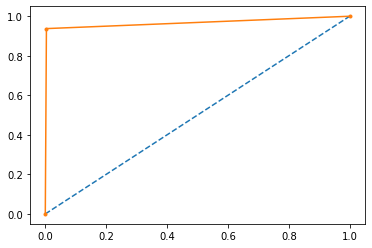

In [70]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import matplotlib.pyplot as plt
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred_model)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()
plt.show()

In [56]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=100)
logreg.fit(X_resampled, y_resampled)
result = logreg.score(X_val, y_val)
print("LR Accuracy: %.2f%%" % (result*100.0))
print("LR Accuracy on Test Set: %.2f%%" % (logreg.score(X_test,y_test)*100.0))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LR Accuracy: 97.66%
LR Accuracy on Test Set: 97.42%


In [71]:
y_pred_logreg = logreg.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred_logreg))
print(classification_report(y_test,y_pred_logreg))

[[9726  258]
 [   0   16]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99      9984
           1       0.06      1.00      0.11        16

    accuracy                           0.97     10000
   macro avg       0.53      0.99      0.55     10000
weighted avg       1.00      0.97      0.99     10000



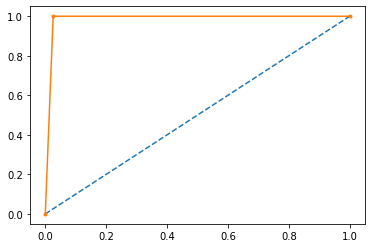

In [72]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import matplotlib.pyplot as plt
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred_logreg)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()
plt.show()

In [57]:
from sklearn.tree import DecisionTreeClassifier 
dtree = DecisionTreeClassifier(max_depth = 2).fit(X_resampled, y_resampled) 
result = dtree.score(X_val, y_val)
print("DT Accuracy: %.2f%%" % (result*100.0))
print("DT Accuracy on Test Set: %.2f%%" % (dtree.score(X_test,y_test)*100.0))

DT Accuracy: 96.00%
DT Accuracy on Test Set: 95.93%


In [79]:
y_pred_dtree = dtree.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred_dtree))
print(classification_report(y_test,y_pred_dtree))

[[9581  403]
 [   4   12]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      9984
           1       0.03      0.75      0.06        16

    accuracy                           0.96     10000
   macro avg       0.51      0.85      0.52     10000
weighted avg       1.00      0.96      0.98     10000



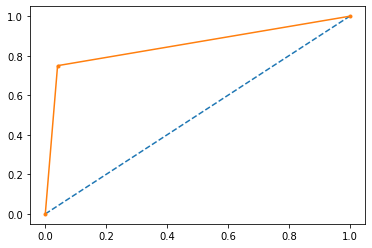

In [80]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import matplotlib.pyplot as plt
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred_dtree)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()
plt.show()

In [76]:
from sklearn.naive_bayes import GaussianNB 
gnb = GaussianNB().fit(X_resampled, y_resampled) 
result = gnb.score(X_val, y_val)
print("NB Accuracy: %.2f%%" % (result*100.0))
print("NB Accuracy on Test Set: %.2f%%" % (gnb.score(X_test,y_test)*100.0))

NB Accuracy: 49.04%
NB Accuracy on Test Set: 48.72%


In [78]:
y_pred_gnb = gnb.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred_gnb))
print(classification_report(y_test,y_pred_gnb))

[[4856 5128]
 [   0   16]]
              precision    recall  f1-score   support

           0       1.00      0.49      0.65      9984
           1       0.00      1.00      0.01        16

    accuracy                           0.49     10000
   macro avg       0.50      0.74      0.33     10000
weighted avg       1.00      0.49      0.65     10000



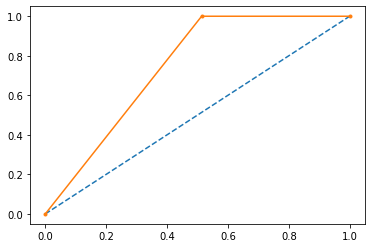

In [81]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import matplotlib.pyplot as plt
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred_gnb)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()
plt.show()

In [60]:
from sklearn.ensemble import VotingClassifier
enclf = VotingClassifier(estimators=[('lr', logreg), ('dt', dtree),('nb', gnb)], voting='soft')
labels = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'Ensemble']
for clf, label in zip([logreg, dtree, gnb, enclf], labels):

    scores = model_selection.cross_val_score(clf, X_resampled, y_resampled, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" 
          % (scores.mean(), scores.std(), label))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

Accuracy: 0.98 (+/- 0.00) [Logistic Regression]
Accuracy: 0.93 (+/- 0.02) [Decision Tree]
Accuracy: 0.74 (+/- 0.01) [Naive Bayes]


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to '

Accuracy: 0.96 (+/- 0.02) [Ensemble]


In [61]:
enclf.fit(X_resampled,y_resampled)
print("Ensemble Accuracy on Test Set: %.2f%%" % (enclf.score(X_test,y_test)*100.0))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Ensemble Accuracy on Test Set: 93.66%


In [82]:
y_pred_enclf = enclf.predict(X_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test,y_pred_enclf))
print(classification_report(y_test,y_pred_enclf))

[[9350  634]
 [   0   16]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      9984
           1       0.02      1.00      0.05        16

    accuracy                           0.94     10000
   macro avg       0.51      0.97      0.51     10000
weighted avg       1.00      0.94      0.97     10000



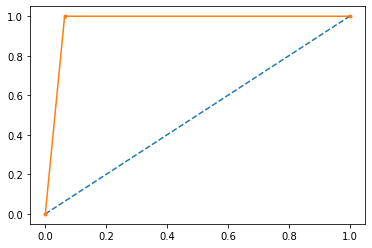

In [83]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot
import matplotlib.pyplot as plt
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test,y_pred_enclf)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle = '--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()
plt.show()